In [1]:
%matplotlib inline

In [2]:
import numpy as np
import radarkit
import algorithms
import chart
import importlib

In [3]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Arial', 'Helvetica']
matplotlib.rcParams['font.sans-serif'] = ['System Font', 'Verdana', 'Arial']
matplotlib.rcParams['figure.figsize'] = (8.89, 5)   # Change the size of plots
matplotlib.rcParams['figure.dpi'] = 144

In [4]:
sweep = radarkit.read('/Users/boonleng/Downloads/PX-20170220-050706-E2.4-Z.nc')

z = sweep['moments'][0]['data']
p = sweep['moments'][4]['data']
r = sweep['moments'][5]['data']

In [5]:
# Undo range correction and the ZCal in DSP to estimate the SNR
rr = 1.0e-3 * (np.arange(sweep['gateCount']) + 0.5) * sweep['gateSizeMeters']
snr = z - 20.0 * np.log10(rr) + 23

# Transition gate at 10.5 km at the given spacing
downSamplingRatio = int(sweep['gateSizeMeters'] / 30.0)
g = int((69.0e-6 * 3.0e8 * 0.5) / 30.0) + 5
g = int((g + downSamplingRatio - 1) / downSamplingRatio)

print(g)

z_off = 10.0 * np.log10(1.5 / 67)
snr[:, :g] = snr[:, :g] + z_off

# PhiDP calibration so that the transition is smooth and PhiDP starts ~ 0 deg
p[:, :g] = p[:, :g] + 40;
p[:, g:] = p[:, g:] + 44;

88


In [8]:
import time

In [9]:
gateSpacing = 1.0e-3 * sweep['gateSizeMeters']

In [10]:
s = time.time()
zc = algorithms.scwc(snr, z, p, r, gate_spacing=gateSpacing)
e = time.time()
print(e - s)

0.7356240749359131


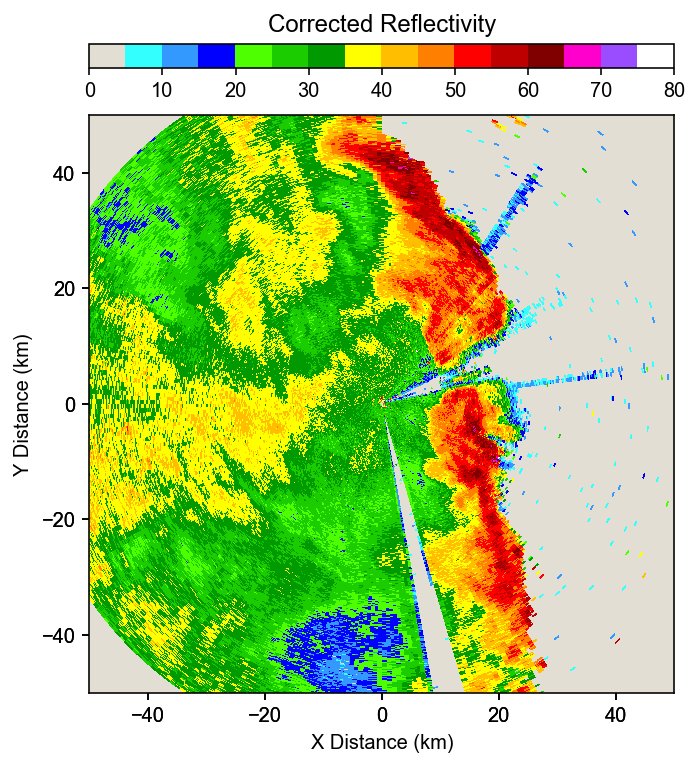

In [11]:
# Original range (km) and zimuth (rad) of the data
r, a = np.meshgrid(1.0e-3 * sweep['range'], sweep['azimuth'] * (np.pi / 180.0))

# Cartesian coordinate of the radar cells
x = r * np.sin(a)
y = r * np.cos(a)

_ = chart.showPPI(x, y, zc, title='Corrected Reflectivity', maxrange=50.0)